In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential    
from keras.layers import Dense, Dropout, LSTM
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

%matplotlib inline

sns.set_style('darkgrid')
default_fig_size = (8,4)

In [95]:
df = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df.index = pd.DatetimeIndex(df.index)
df.index = df.index.map(datetime.toordinal) # zamiana daty na liczby całkowite


stocks = {}
for col in df.columns:
    stocks[col] = df[[col]]

stocks['AAPL']

,AAPL
Date,
735008,13.733949
735009,13.632556
735010,13.684957
735011,13.709449
735012,13.802786
...,...
738650,173.320267
738651,173.510010
738652,172.570007


# Podział na zbiór treningowy i testowy

In [96]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(stocks['AAPL'].index, stocks['AAPL'].values, test_size=test_size, shuffle=False)
print('Rozmiar zbioru treningowego:', len(X_train))
print('Rozmiar zbioru testowego:', len(X_test))

Rozmiar zbioru treningowego: 2012
Rozmiar zbioru testowego: 504


# Funkcje pomocnicze

In [99]:
def evaluate_model(y_test, y_pred):
    r2 = np.round(r2_score(y_test, y_pred), 2)
    mse = np.round(mean_squared_error(y_test, y_pred), 2)
    mae = np.round(mean_absolute_error(y_test, y_pred), 2)

    df = pd.DataFrame(data=[r2, mse, mae], index=['R2', 'MSE', 'MAE'], columns=['Wartość'])
    return df
    
    # print('R2:', r2)
    # print('MSE:', mse)
    # print('MAE:', mae)

# Regresja liniowa

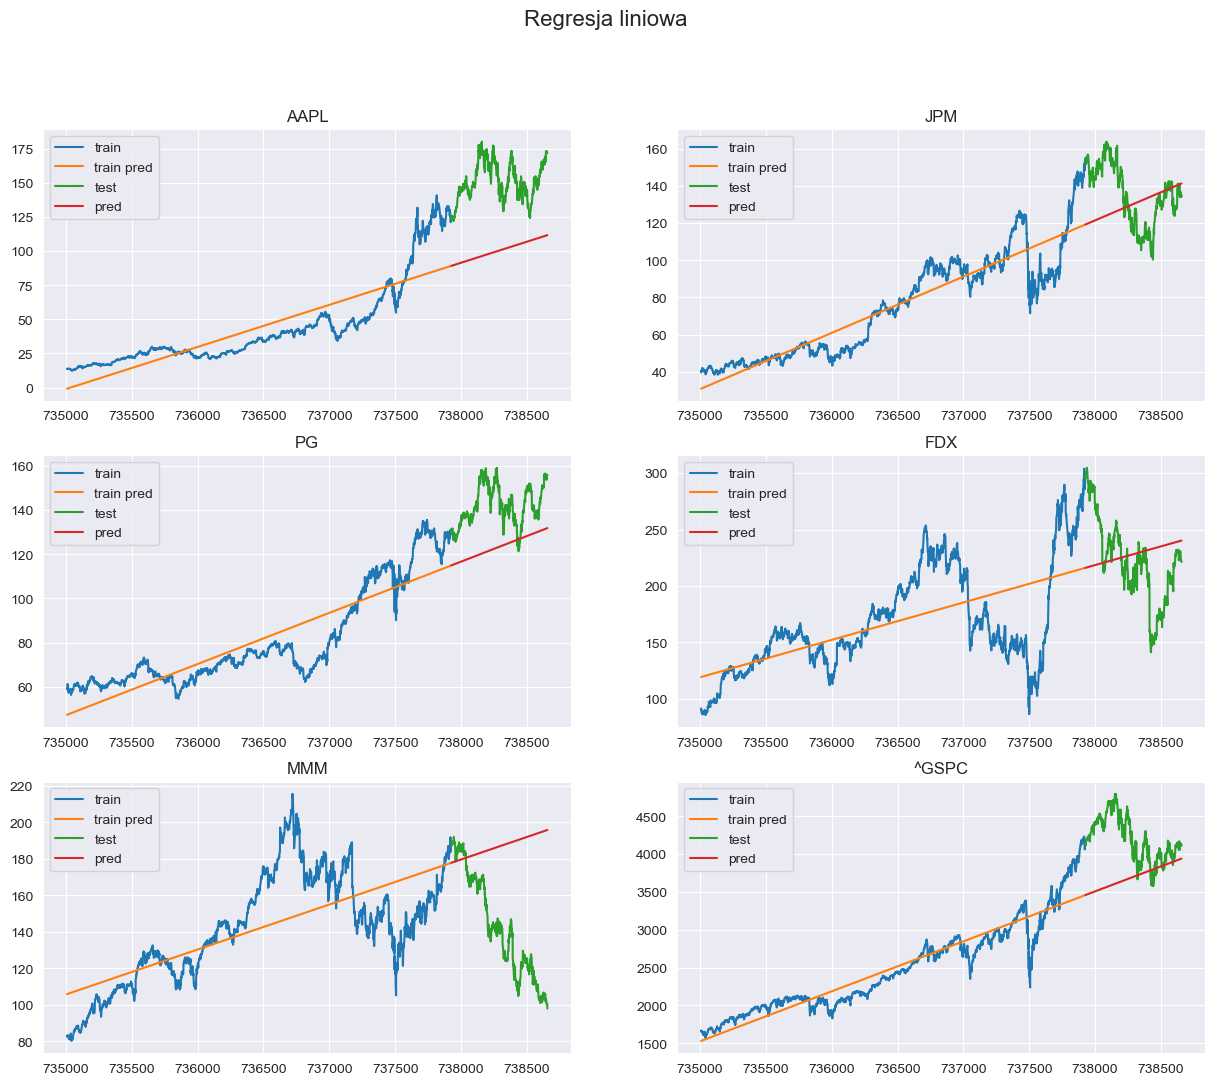

,AAPL,JPM,PG,FDX,MMM,^GSPC
R2,-14.31,-0.71,-4.43,-0.35,-2.89,-3.88
MSE,2794.66,436.60,423.30,1756.17,2984.88,405532.21
MAE,51.00,17.47,18.74,33.05,45.72,513.96


In [100]:
def linear_regression_model(data, ax):
        X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
        X_train = X_train.values.reshape(-1, 1)
        X_test = X_test.values.reshape(-1, 1)

        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_pred = lr.predict(X_test)

        ax.plot(X_train, y_train, label='train')
        ax.plot(X_train, y_train_pred, label='train pred')
        ax.plot(X_test, y_test, label='test')
        ax.plot(X_test, y_pred, label='pred')
        ax.legend(loc=2)
        ax.set_title(stock)

        results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Regresja liniowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        linear_regression_model(stocks[stock], ax)

plt.show()
results_df

# Regresja wielomianowa

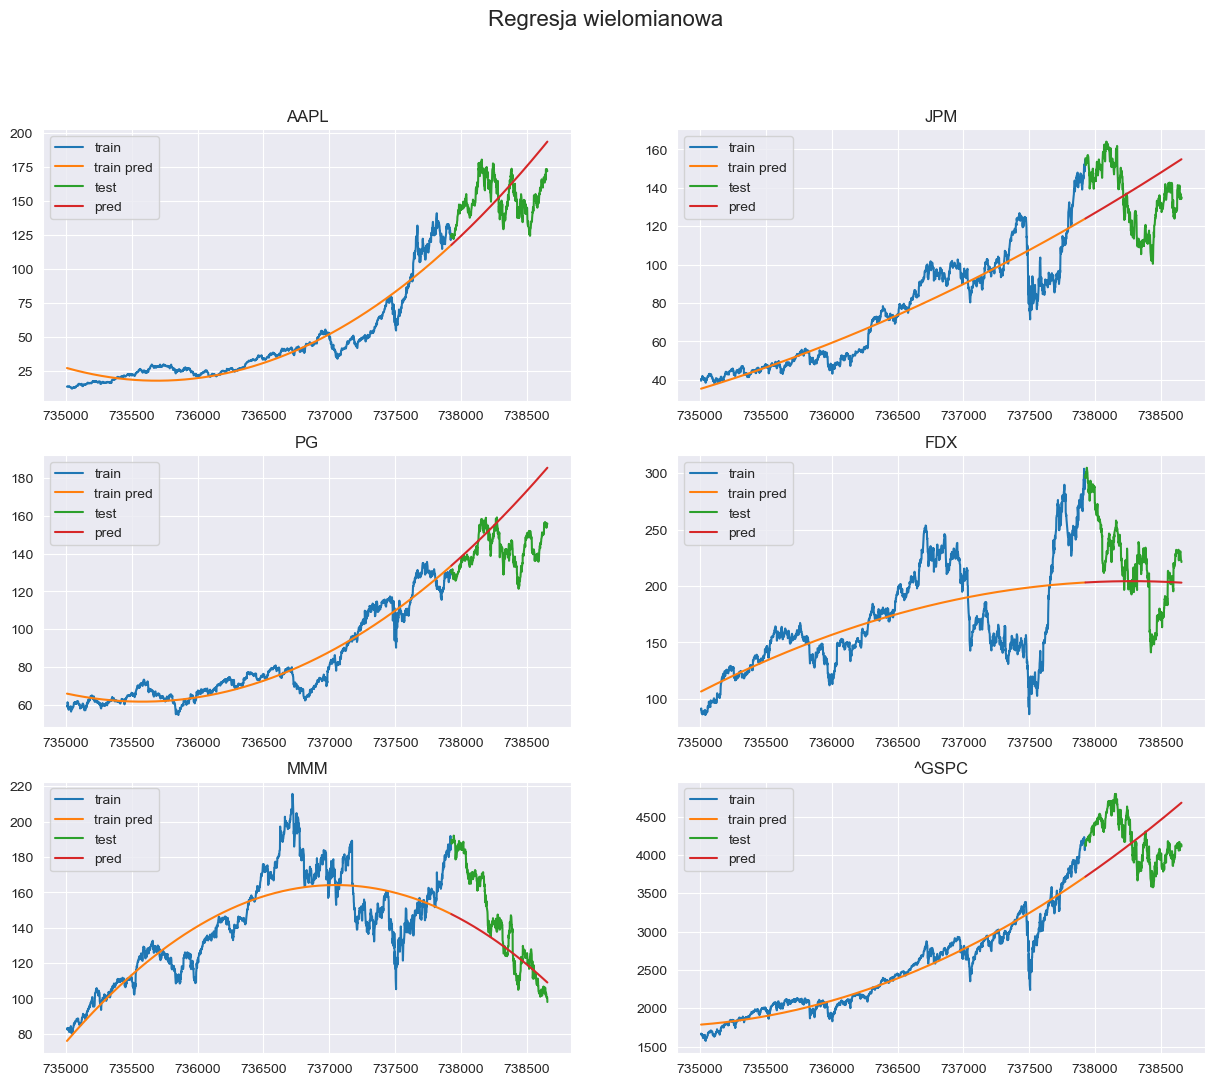

,AAPL,JPM,PG,FDX,MMM,^GSPC
R2,-2.13,-0.98,-5.41,-0.24,0.40,-2.20
MSE,571.86,507.21,499.99,1612.63,463.96,266014.15
MAE,21.18,20.81,17.44,31.74,16.77,481.44


In [101]:
def polynomial_regression_model(data, ax):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    poly_reg = PolynomialFeatures(degree=4)
    X_train_poly = poly_reg.fit_transform(X_train)
    X_test_poly = poly_reg.fit_transform(X_test)

    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    y_train_pred = poly_reg.predict(X_train_poly)
    y_pred = poly_reg.predict(X_test_poly)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Regresja wielomianowa', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        polynomial_regression_model(stocks[stock], ax)

plt.show()
results_df

# Support Vector Machine

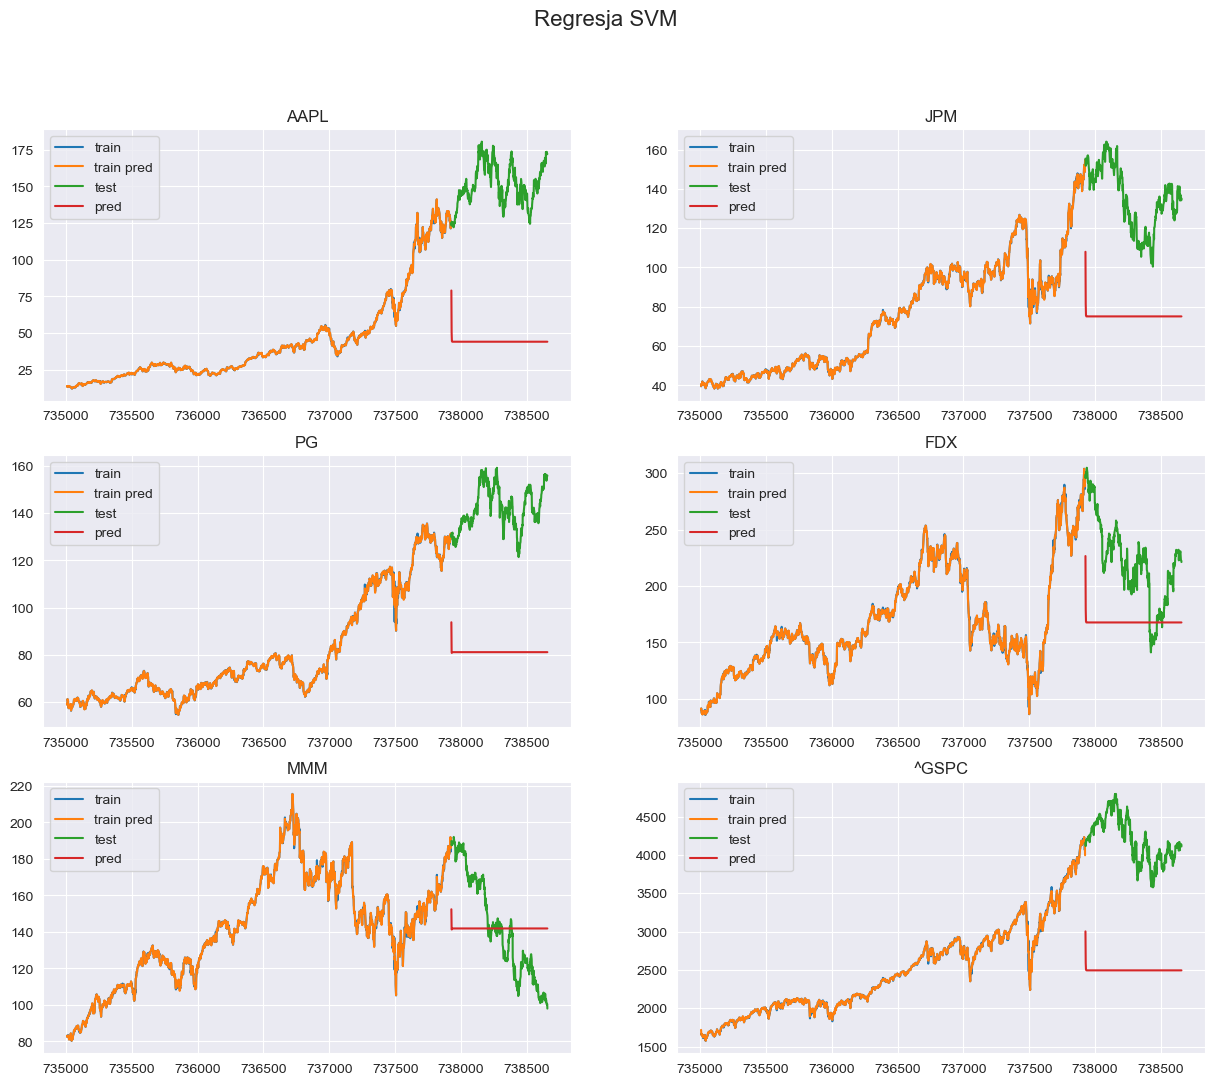

,AAPL,JPM,PG,FDX,MMM,^GSPC
R2,-63.01,-14.13,-47.49,-2.16,0.00,-35.01
MSE,11684.55,3874.81,3780.18,4121.85,767.20,2990336.86
MAE,107.20,60.17,60.84,55.61,23.78,1704.83


In [102]:
def svm_regression_model(data, ax, kernel='rbf'):
    X_train, X_test, y_train, y_test = train_test_split(data.index, data.values, test_size=test_size, shuffle=False)
    X_train = X_train.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    svr = SVR(kernel=kernel, C=1e3, gamma=0.1)
    svr.fit(X_train, y_train)
    y_train_pred = svr.predict(X_train)
    y_pred = svr.predict(X_test)

    ax.plot(X_train, y_train, label='train')
    ax.plot(X_train, y_train_pred, label='train pred')
    ax.plot(X_test, y_test, label='test')
    ax.plot(X_test, y_pred, label='pred')
    ax.legend(loc=2)
    ax.set_title(stock)

    results_df[stock] = evaluate_model(y_test, y_pred)['Wartość']

results_df = pd.DataFrame()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Regresja SVM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
        svm_regression_model(stocks[stock], ax)

plt.show()
results_df

# Model LSTM

3/3 [==============================] - 1s 10ms/step


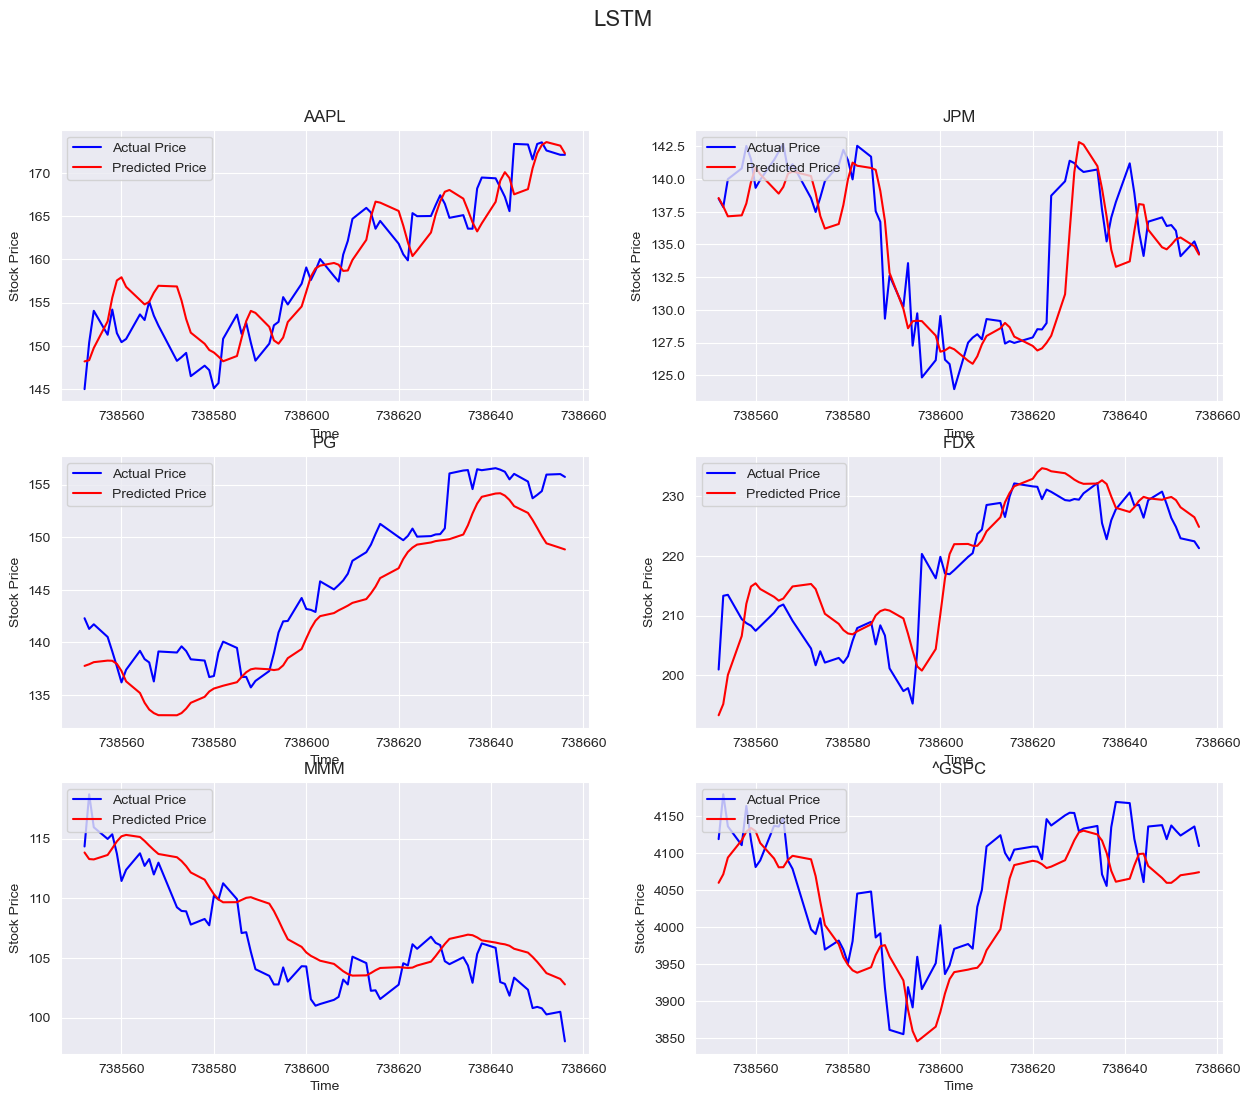

,AAPL,JPM,PG,FDX,MMM,^GSPC
R2,0.83,0.71,0.75,0.68,0.58,0.47
MSE,11.51,9.07,12.58,38.38,8.68,3709.32
MAE,2.82,2.23,3.06,4.68,2.51,50.44


In [103]:
def lstm_model(data, ax):
    training_set = data.iloc[:int(len(data)*0.8), 0:1].values
    test_set = data.iloc[int(len(data)*0.8):, 0:1].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(training_set)

    X_train = []
    y_train = []
    for i in range(60, len(training_set)):
        X_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    inputs = data[len(data) - len(test_set) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred)

    ax.plot(data[len(data) - len(test_set):].index, data[len(data) - len(test_set):].values, color='blue', label='Actual Price')
    ax.plot(data[len(data) - len(test_set):].index, y_pred, color='red', label='Predicted Price')
    ax.legend(loc=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Stock Price')
    ax.set_title(stock)

    results_df[stock] = evaluate_model(data[len(data) - len(test_set):].values, y_pred)['Wartość']
    
results_df = pd.DataFrame() 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('LSTM', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    lstm_model(stocks[stock].iloc[-365:], ax)

plt.show()
results_df

Taki model przewiduje wartość danego dnia jako wartość poprzedniego dnia + bias. Nie jest w stanie generować predykcji dla więcej niż 1 dnia oraz nawet przy generowaniu predykcji dla dnia następnego może nie być lepszy od modelu naiwnego.


# Prophet

19:58:19 - cmdstanpy - INFO - Chain [1] start processing
19:58:19 - cmdstanpy - INFO - Chain [1] done processing
19:58:20 - cmdstanpy - INFO - Chain [1] start processing



STOCK:  AAPL
     Wartość
R2     -5.53
MSE  1191.13
MAE    27.12


19:58:20 - cmdstanpy - INFO - Chain [1] done processing
19:58:21 - cmdstanpy - INFO - Chain [1] start processing



STOCK:  JPM
     Wartość
R2     -0.85
MSE   472.76
MAE    18.04


19:58:21 - cmdstanpy - INFO - Chain [1] done processing
19:58:22 - cmdstanpy - INFO - Chain [1] start processing



STOCK:  PG
     Wartość
R2      0.17
MSE    64.34
MAE     6.17


19:58:22 - cmdstanpy - INFO - Chain [1] done processing
19:58:23 - cmdstanpy - INFO - Chain [1] start processing



STOCK:  FDX
      Wartość
R2     -14.62
MSE  20353.26
MAE    126.95


19:58:23 - cmdstanpy - INFO - Chain [1] done processing
19:58:24 - cmdstanpy - INFO - Chain [1] start processing



STOCK:  MMM
     Wartość
R2     -2.39
MSE  2604.20
MAE    42.59


19:58:24 - cmdstanpy - INFO - Chain [1] done processing



STOCK:  ^GSPC
       Wartość
R2       -2.41
MSE  283019.00
MAE     479.79


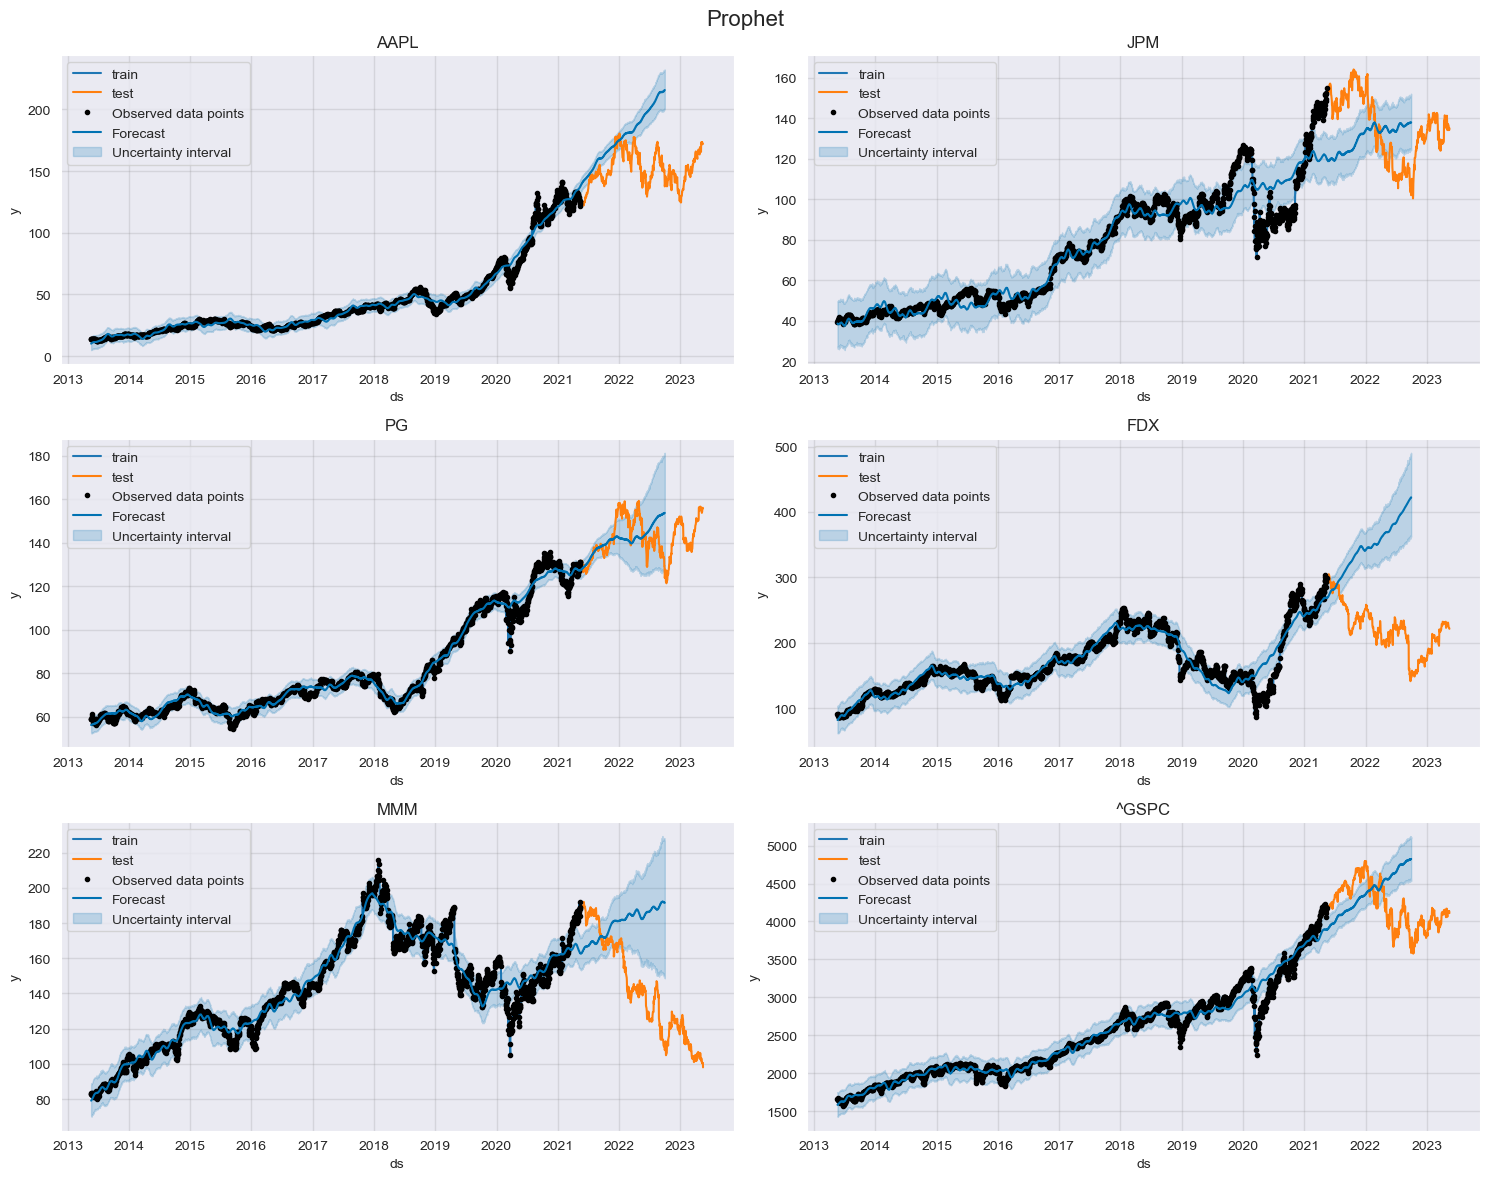

In [87]:
from prophet import Prophet

df = pd.read_csv('data/close_prices_clean.csv', parse_dates=True, index_col=0)
df.index = pd.DatetimeIndex(df.index)
stocks = {}
for col in df.columns:
    stocks[col] = df[[col]]


def prophet_model(data, ax):
    data = data.reset_index().rename(columns={'Date':'ds', data.columns[0]:'y'})
    X_train, X_test, y_train, y_test = train_test_split(data, data.y, test_size=test_size, shuffle=False)
    m = Prophet(daily_seasonality=True)
    m.fit(X_train)

    future = m.make_future_dataframe(periods=len(X_test)) #we need to specify the number of days in future
    y_pred = m.predict(future)
    y_pred_values = y_pred[['ds', 'yhat']].set_index('ds') # for evaluation

    ax.plot(X_train.ds, y_train, label='train')
    ax.plot(X_test.ds, y_test, label='test')
    m.plot(y_pred, ax=ax)
    # m.plot_components(y_pred) # plots trend, weekly and yearly, daily
    ax.legend(loc=2)
    ax.set_title(stock)

    print('\nSTOCK: ', stock)
    print(evaluate_model(y_test, y_pred_values.yhat[-len(y_test):].values))


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Prophet', fontsize=16)
for ax, stock in zip(axes.flatten(), stocks):
    prophet_model(stocks[stock], ax)

plt.show()